<a href="https://colab.research.google.com/github/Code-Trees/CNN/blob/master/Mnist_Modules_All_Norms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
!pwd

/content


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.nn.functional as F
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.nn.modules.batchnorm import BatchNorm2d

In [5]:
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [6]:
!pip install rf_calc
from rf_calc import receptive_field

In [7]:
import numpy as np
from torchsummary import summary

In [8]:
def clean_gpu():
    """Considering we have GPUs"""

    gc.collect()
    torch.cuda.empty_cache()
    return None

In [9]:
def Normalize(norm_type,num_features,n_group=2):
    if norm_type == 'bn':
        return nn.BatchNorm2d(num_features = num_features)

    elif norm_type =='gn':
        return nn.GroupNorm(num_groups=n_group ,num_channels=num_features)
    
    elif norm_type =='ln':
        return nn.GroupNorm(num_groups =1, num_channels=num_features)

    elif norm_type == 'gbn':
        return  GhostBatchNorm(num_features, num_splits=4, weight=False)
        
    else:
        print ('Invalid norm Parameter, Providing Default as BN ')
        return nn.BatchNorm2d(num_features = num_features,)

In [10]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)

In [11]:

class Mnist_net(nn.Module):
    def __init__(self,norm_type):
        super(Mnist_net,self).__init__()
        self.drop_val =0.01
        self.norm_type = norm_type

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=8),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=10),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=16),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=10),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=16),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=16),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            Normalize(norm_type=self.norm_type,num_features=16),
            nn.ReLU(),
            nn.Dropout(self.drop_val)
        ) # input_size = 7 output_size = 5 receptive_field = 21
        
        
        self.gap = nn.AvgPool2d(kernel_size=(5,5))
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 5 output_size = 3  receptive_field = 29

        self.fc1 = nn.Linear(in_features =16,out_features = 10 )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x =x.view(-1,16)
        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (f'running on {device}')

model_try = Mnist_net('bn').to(device)
summary(model_try,input_size = (1,28,28))
rf_df = receptive_field(model_try,28)

running on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14   

In [13]:
# # This is a Try

# for data,target in train_loader:
#     data,target = data.to(device),target.to(device)
#     break
# data1 = data[0]
# data1 = data1.reshape(-1,1,28,28)
# im = model.forward(data)
# # plt.imshow(data1.reshape(28,28))
# im.shape
# im.view(-1,10)
# target[5]
# im[0].reshape(-1,10)
# summary(model,(1,28,28),)\

In [14]:
#@title Default title text
# # This is a Try

# for data,target in train_loader:
#     data,target = data.to(device),target.to(device)
#     break
# data1 = data[0]
# data1 = data1.reshape(-1,1,28,28)
# im = model.forward(data)
# # plt.imshow(data1.reshape(28,28))
# im.shape
# im.view(-1,10)
# target[5]
# im[0].reshape(-1,10)
# summary(model,(1,28,28))
# im = model(data)
# lo = f.nll_loss(im,target,reduction = 'sum')

In [15]:
#L1 Loss
def get_optimizer(model_obj,loss_type=None,scheduler = False):
    loss_type= str(loss_type).upper()
    parameters = model_obj.parameters()
    if loss_type  == 'L2' :
        optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9,weight_decay= 0.001)
    else:
        optimizer = SGD( params = parameters,lr = 0.01,momentum = 0.9)
    if scheduler == True:
        scheduler = StepLR(optimizer,step_size = 6,gamma = 0.1)
        return optimizer,scheduler
    else:
        return optimizer,_

def L1_loss(model_obj,loss):
        
    l1 = 0
    lambda_l1 = 0.0001
    for p in model_obj.parameters():
        l1 = l1+p.abs().sum()
        loss = loss+ lambda_l1* l1
    return loss

In [16]:
train_losses = []
train_accuracy = []
test_losses =[]
test_accuracy = []

def trainning(model,device,train_data,optimizer,epochs,L1 = False,L2= False):
    total_loss = 0
    correct = 0
    processed = 0

    model.train()
    pbar = tqdm(train_loader)
    
    for index_id,(data,target) in enumerate(pbar):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.nll_loss(output,target)
        if L1 == True:
            loss = L1_loss(model,loss)

        total_loss += loss
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim = 1).eq(target).sum().item()
        processed += len(data)
        pbar.set_description(f"Epochs: {epochs} Batch:  {index_id} loss: {loss} Accuracy: { correct/processed *100 :.2f}% ")

    acc = correct /processed
    train_losses.append(total_loss.item())
    train_accuracy.append(acc)

    return train_losses, train_accuracy


def testing(model,device,test_data,optimizer,epochs):
    model.eval()
    
    test_loss = 0
    correct = 0
    processed = 0

    with torch.no_grad():
        for id_x,(data,target) in enumerate(test_loader):
            data,target = data.to(device),target.to(device)

            output = model(data)
            test_loss += f.nll_loss(output,target,reduce='sum').item()
            pred  = output.argmax(dim =1,keepdim = True)

            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            
            # print_wrong_image(output,target,data)
    
    acc = correct / processed
    test_loss /= processed

    test_accuracy.append(acc)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, processed, 100. * correct / processed))
    
    return test_losses,test_accuracy


def print_wrong_image(model,device,data,label,n_images):
    if n_images >= 10:
        n_images = 10

    with torch.no_grad():

        out = model((data/255).to(torch.float32).reshape(-1,1,28,28).to(device))
    
    wrong_idx = (out.to(device).argmax(dim = 1).eq(label.to(device)) ==False).nonzero()
    label = label.to('cpu')
    img_data = (data/255).to(torch.float32).to('cpu')
    wrong_idx = wrong_idx.to('cpu').squeeze()
    # print (wrong_idx.shape)
    # wrong_idx
    np.random.shuffle(wrong_idx.numpy())
    fig = plt.figure(figsize=(20,30))
    count = 1
    for image_index in wrong_idx:
        n= image_index
        ax = fig.add_subplot(1,10,count)
        _=plt.imshow((img_data[n].reshape(28,28).to('cpu')))
        _=plt.title(f"idx:{n }")
        _=plt.xlabel(f"Act:{label[n].item()} ")
        _=plt.ylabel(f"Pred: {out.argmax(dim = 1)[n].item()} ")
        _ = plt.autoscale()
        fig.tight_layout(pad = 1.0)
        count+= 1
        if count==11:
            break
    plt.show()

In [17]:
def Run_Model(model_class,train_loader,test_loader,epochs , L1 = False):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        summary(model,input_size = (1,28,28))
    except:
        pass

    optimizer,scheduler = get_optimizer(model,scheduler = True )
    # optimizer = SGD( params = model.parameters(),lr = 0.01,momentum = 0.9)
    for EPOCHS in range(0,epochs):
        if L1 == True:
            train_losses, train_accuracy = trainning(model,device,train_loader,optimizer,EPOCHS,L1 = L1)
        else:
            train_losses, train_accuracy = trainning(model,device,train_loader,optimizer,EPOCHS)
        test_losses,test_accuracy = testing(model,device,test_loader,optimizer,EPOCHS)
        scheduler.step()
    return model,train_losses, train_accuracy,test_losses,test_accuracy

In [18]:
def get_data():
    
    train = datasets.MNIST(root = './',train = True,download=True,transform=transforms.Compose([transforms.ToTensor(),
                                                                                            transforms.Normalize((0.13066062331199646,),(0.30810776352882385,)),
                                                                                            transforms.RandomRotation((-7,7) ,fill = 0.13066062331199646)
                                                                                            ])) 
    test = datasets.MNIST(root = './',train = False,download=True,transform=transforms.Compose([transforms.ToTensor(),
                                                                                            transforms.Normalize((0.13066062331199646,),(0.30810776352882385,))                                                                                            
                                                                                            ]))
    return train,test

In [19]:
# def plot_model_performance(train_losses, train_accuracy,test_losses,test_accuracy):
#     fig,axis = plt.subplots(2,2,figsize=(15,5))
#     _ = axis[0][0].plot(train_losses)
#     _ = axis[0][1].plot(train_accuracy)
#     _ = axis[1][0].plot(test_losses)
#     _ = axis[1][1].plot(test_accuracy)
#     _ = plt.autoscale()
#     _ = plt.show()




def plot_acc_loss(typ ,train_acc,train_losses,test_acc,test_losses):
    fig, axs = plt.subplots(1,2,figsize = (20,5))
    # print ('Accuracy model on  ', typ)
    plt.autoscale()
    axs[0].plot(train_acc,color = 'red')
    axs[0].plot(test_acc,color = 'green')
    title = 'Training/testing accuracy'
    axs[0].set_title(title)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc','test acc'], loc='best')
       
    axs[1].plot(train_losses,color = 'red')
    axs[1].plot(test_losses,color = 'green')
    title = 'Training/Testing Loss'
    axs[1].set_title(title)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train loss','test loss'], loc='best')
    plt.title(typ + ' model Accuracy Vs Loss')

    plt.show()
    fig.tight_layout(pad = 1.0)

running on cuda 



Epochs: 0 Batch:  937 loss: 0.17197833955287933 Accuracy: 87.67% : 100%|██████████| 938/938 [00:18<00:00, 51.17it/s]



Test set: Average loss: 0.0013, Accuracy: 9813/10000 (98.130000%)



Epochs: 1 Batch:  937 loss: 0.1317230612039566 Accuracy: 97.09% : 100%|██████████| 938/938 [00:15<00:00, 60.02it/s]



Test set: Average loss: 0.0011, Accuracy: 9816/10000 (98.160000%)



Epochs: 2 Batch:  937 loss: 0.10273602604866028 Accuracy: 97.64% : 100%|██████████| 938/938 [00:15<00:00, 59.42it/s]



Test set: Average loss: 0.0006, Accuracy: 9901/10000 (99.010000%)



Epochs: 3 Batch:  937 loss: 0.12502065300941467 Accuracy: 98.02% : 100%|██████████| 938/938 [00:15<00:00, 58.97it/s]



Test set: Average loss: 0.0005, Accuracy: 9907/10000 (99.070000%)



Epochs: 4 Batch:  937 loss: 0.06302908807992935 Accuracy: 98.23% : 100%|██████████| 938/938 [00:16<00:00, 57.85it/s]



Test set: Average loss: 0.0005, Accuracy: 9911/10000 (99.110000%)



Epochs: 5 Batch:  937 loss: 0.05620800331234932 Accuracy: 98.28% : 100%|██████████| 938/938 [00:15<00:00, 58.71it/s]



Test set: Average loss: 0.0005, Accuracy: 9908/10000 (99.080000%)



Epochs: 6 Batch:  937 loss: 0.24608831107616425 Accuracy: 98.63% : 100%|██████████| 938/938 [00:16<00:00, 58.58it/s]



Test set: Average loss: 0.0004, Accuracy: 9938/10000 (99.380000%)



Epochs: 7 Batch:  937 loss: 0.04366718977689743 Accuracy: 98.73% : 100%|██████████| 938/938 [00:15<00:00, 60.11it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 8 Batch:  937 loss: 0.054259855300188065 Accuracy: 98.78% : 100%|██████████| 938/938 [00:16<00:00, 57.84it/s]



Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.390000%)



Epochs: 9 Batch:  937 loss: 0.019173087552189827 Accuracy: 98.75% : 100%|██████████| 938/938 [00:15<00:00, 59.55it/s]



Test set: Average loss: 0.0003, Accuracy: 9937/10000 (99.370000%)



Epochs: 10 Batch:  937 loss: 0.07710960507392883 Accuracy: 98.78% : 100%|██████████| 938/938 [00:15<00:00, 60.23it/s]



Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.390000%)



Epochs: 11 Batch:  937 loss: 0.14407216012477875 Accuracy: 98.84% : 100%|██████████| 938/938 [00:16<00:00, 58.05it/s]



Test set: Average loss: 0.0003, Accuracy: 9936/10000 (99.360000%)



Epochs: 12 Batch:  937 loss: 0.058199960738420486 Accuracy: 98.88% : 100%|██████████| 938/938 [00:15<00:00, 58.96it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 13 Batch:  937 loss: 0.08315987139940262 Accuracy: 98.81% : 100%|██████████| 938/938 [00:15<00:00, 58.76it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 14 Batch:  937 loss: 0.03603074327111244 Accuracy: 98.84% : 100%|██████████| 938/938 [00:16<00:00, 57.28it/s]



Test set: Average loss: 0.0003, Accuracy: 9936/10000 (99.360000%)



Epochs: 15 Batch:  937 loss: 0.06248050183057785 Accuracy: 98.85% : 100%|██████████| 938/938 [00:15<00:00, 59.35it/s]



Test set: Average loss: 0.0003, Accuracy: 9940/10000 (99.400000%)



Epochs: 16 Batch:  937 loss: 0.02650812827050686 Accuracy: 98.86% : 100%|██████████| 938/938 [00:15<00:00, 59.51it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 17 Batch:  937 loss: 0.05613872408866882 Accuracy: 98.83% : 100%|██████████| 938/938 [00:15<00:00, 59.78it/s]



Test set: Average loss: 0.0003, Accuracy: 9935/10000 (99.350000%)



Epochs: 18 Batch:  937 loss: 0.02281096577644348 Accuracy: 98.76% : 100%|██████████| 938/938 [00:15<00:00, 59.68it/s]



Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.410000%)



Epochs: 19 Batch:  937 loss: 0.05099115148186684 Accuracy: 98.80% : 100%|██████████| 938/938 [00:15<00:00, 60.38it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 20 Batch:  937 loss: 0.03324463218450546 Accuracy: 98.90% : 100%|██████████| 938/938 [00:15<00:00, 58.94it/s]



Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.410000%)



Epochs: 21 Batch:  937 loss: 0.042154040187597275 Accuracy: 98.90% : 100%|██████████| 938/938 [00:15<00:00, 59.76it/s]



Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.450000%)



Epochs: 22 Batch:  937 loss: 0.06887223571538925 Accuracy: 98.77% : 100%|██████████| 938/938 [00:16<00:00, 56.31it/s]



Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.410000%)



Epochs: 23 Batch:  937 loss: 0.06458013504743576 Accuracy: 98.84% : 100%|██████████| 938/938 [00:15<00:00, 59.93it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 24 Batch:  937 loss: 0.10263899713754654 Accuracy: 98.84% : 100%|██████████| 938/938 [00:15<00:00, 59.87it/s]



Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.420000%)



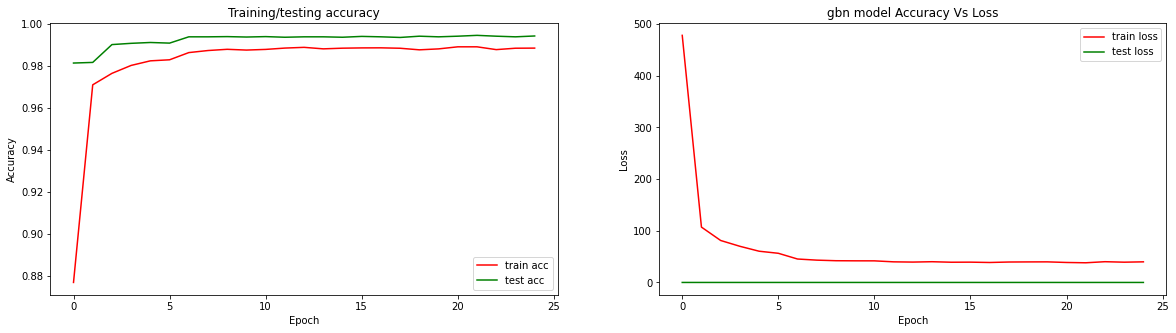

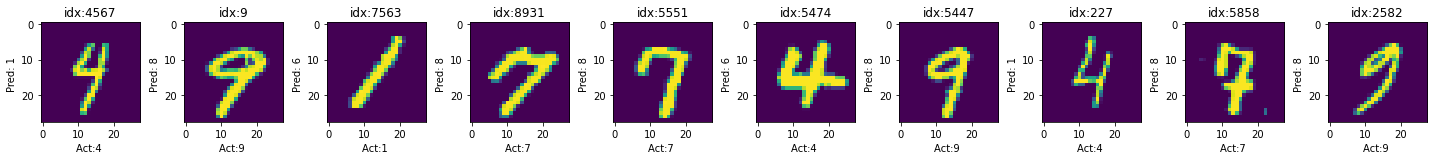

running on cuda 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14 

Epochs: 0 Batch:  937 loss: 0.04877994954586029 Accuracy: 90.23% : 100%|██████████| 938/938 [00:15<00:00, 61.33it/s]



Test set: Average loss: 0.0009, Accuracy: 9841/10000 (98.410000%)



Epochs: 1 Batch:  937 loss: 0.02282777614891529 Accuracy: 97.98% : 100%|██████████| 938/938 [00:15<00:00, 62.35it/s]



Test set: Average loss: 0.0007, Accuracy: 9877/10000 (98.770000%)



Epochs: 2 Batch:  937 loss: 0.0052589187398552895 Accuracy: 98.42% : 100%|██████████| 938/938 [00:15<00:00, 61.47it/s]



Test set: Average loss: 0.0005, Accuracy: 9911/10000 (99.110000%)



Epochs: 3 Batch:  937 loss: 0.014315768145024776 Accuracy: 98.66% : 100%|██████████| 938/938 [00:15<00:00, 61.53it/s]



Test set: Average loss: 0.0004, Accuracy: 9910/10000 (99.100000%)



Epochs: 4 Batch:  937 loss: 0.019872276112437248 Accuracy: 98.80% : 100%|██████████| 938/938 [00:15<00:00, 62.10it/s]



Test set: Average loss: 0.0004, Accuracy: 9927/10000 (99.270000%)



Epochs: 5 Batch:  937 loss: 0.006057878024876118 Accuracy: 98.87% : 100%|██████████| 938/938 [00:15<00:00, 61.98it/s]



Test set: Average loss: 0.0004, Accuracy: 9920/10000 (99.200000%)



Epochs: 6 Batch:  937 loss: 0.002903899410739541 Accuracy: 99.19% : 100%|██████████| 938/938 [00:15<00:00, 62.02it/s]



Test set: Average loss: 0.0003, Accuracy: 9940/10000 (99.400000%)



Epochs: 7 Batch:  937 loss: 0.032844457775354385 Accuracy: 99.24% : 100%|██████████| 938/938 [00:15<00:00, 61.58it/s]



Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.430000%)



Epochs: 8 Batch:  937 loss: 0.02085643820464611 Accuracy: 99.26% : 100%|██████████| 938/938 [00:15<00:00, 59.08it/s]



Test set: Average loss: 0.0003, Accuracy: 9940/10000 (99.400000%)



Epochs: 9 Batch:  937 loss: 0.028103023767471313 Accuracy: 99.29% : 100%|██████████| 938/938 [00:15<00:00, 62.22it/s]



Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.450000%)



Epochs: 10 Batch:  937 loss: 0.09984082728624344 Accuracy: 99.30% : 100%|██████████| 938/938 [00:15<00:00, 62.24it/s]



Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.450000%)



Epochs: 11 Batch:  937 loss: 0.011033964343369007 Accuracy: 99.34% : 100%|██████████| 938/938 [00:16<00:00, 57.39it/s]



Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.430000%)



Epochs: 12 Batch:  937 loss: 0.011606719344854355 Accuracy: 99.32% : 100%|██████████| 938/938 [00:15<00:00, 59.75it/s]



Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.420000%)



Epochs: 13 Batch:  937 loss: 0.10895073413848877 Accuracy: 99.36% : 100%|██████████| 938/938 [00:15<00:00, 61.13it/s]



Test set: Average loss: 0.0003, Accuracy: 9946/10000 (99.460000%)



Epochs: 14 Batch:  937 loss: 0.011719594709575176 Accuracy: 99.28% : 100%|██████████| 938/938 [00:15<00:00, 61.61it/s]



Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.430000%)



Epochs: 15 Batch:  937 loss: 0.007529567461460829 Accuracy: 99.32% : 100%|██████████| 938/938 [00:15<00:00, 60.98it/s]



Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.450000%)



Epochs: 16 Batch:  937 loss: 0.04394954815506935 Accuracy: 99.34% : 100%|██████████| 938/938 [00:15<00:00, 61.55it/s]



Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.390000%)



Epochs: 17 Batch:  937 loss: 0.0015776477521285415 Accuracy: 99.37% : 100%|██████████| 938/938 [00:15<00:00, 61.76it/s]



Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.430000%)



Epochs: 18 Batch:  937 loss: 0.04396431893110275 Accuracy: 99.37% : 100%|██████████| 938/938 [00:15<00:00, 61.17it/s]



Test set: Average loss: 0.0003, Accuracy: 9947/10000 (99.470000%)



Epochs: 19 Batch:  937 loss: 0.013736103661358356 Accuracy: 99.33% : 100%|██████████| 938/938 [00:15<00:00, 61.47it/s]



Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.420000%)



Epochs: 20 Batch:  937 loss: 0.014224906452000141 Accuracy: 99.35% : 100%|██████████| 938/938 [00:15<00:00, 61.72it/s]



Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.430000%)



Epochs: 21 Batch:  937 loss: 0.04362587258219719 Accuracy: 99.35% : 100%|██████████| 938/938 [00:15<00:00, 60.79it/s]



Test set: Average loss: 0.0003, Accuracy: 9943/10000 (99.430000%)



Epochs: 22 Batch:  937 loss: 0.008415568619966507 Accuracy: 99.33% : 100%|██████████| 938/938 [00:15<00:00, 59.82it/s]



Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.450000%)



Epochs: 23 Batch:  937 loss: 0.048510245978832245 Accuracy: 99.34% : 100%|██████████| 938/938 [00:15<00:00, 60.89it/s]



Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.410000%)



Epochs: 24 Batch:  937 loss: 0.004462724551558495 Accuracy: 99.35% : 100%|██████████| 938/938 [00:15<00:00, 60.57it/s]



Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.450000%)



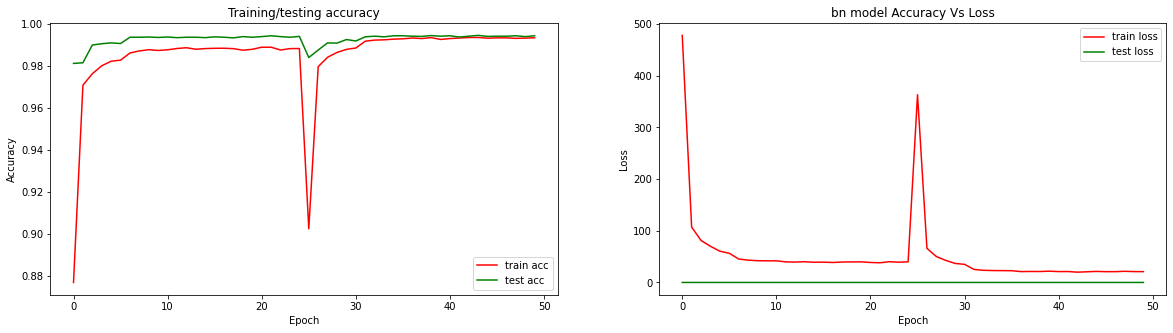

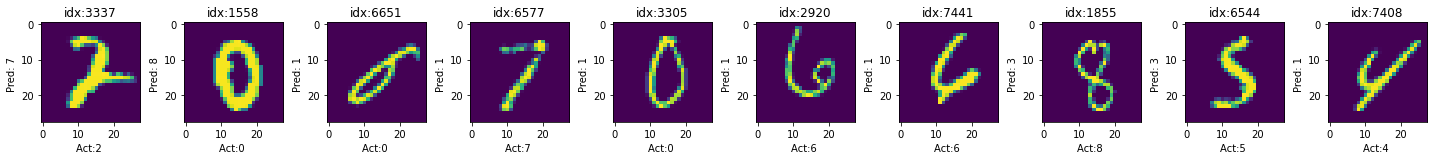

running on cuda 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
         GroupNorm-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
        GroupNorm-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14 

Epochs: 0 Batch:  937 loss: 0.3309836685657501 Accuracy: 84.46% : 100%|██████████| 938/938 [00:15<00:00, 59.43it/s]



Test set: Average loss: 0.0014, Accuracy: 9803/10000 (98.030000%)



Epochs: 1 Batch:  937 loss: 0.09163695573806763 Accuracy: 97.05% : 100%|██████████| 938/938 [00:15<00:00, 59.78it/s]



Test set: Average loss: 0.0008, Accuracy: 9847/10000 (98.470000%)



Epochs: 2 Batch:  937 loss: 0.1308247596025467 Accuracy: 97.86% : 100%|██████████| 938/938 [00:15<00:00, 59.92it/s]



Test set: Average loss: 0.0008, Accuracy: 9848/10000 (98.480000%)



Epochs: 3 Batch:  937 loss: 0.057845234870910645 Accuracy: 98.34% : 100%|██████████| 938/938 [00:15<00:00, 59.82it/s]



Test set: Average loss: 0.0006, Accuracy: 9883/10000 (98.830000%)



Epochs: 4 Batch:  937 loss: 0.011489363387227058 Accuracy: 98.43% : 100%|██████████| 938/938 [00:15<00:00, 59.59it/s]



Test set: Average loss: 0.0006, Accuracy: 9889/10000 (98.890000%)



Epochs: 5 Batch:  937 loss: 0.06586714088916779 Accuracy: 98.59% : 100%|██████████| 938/938 [00:15<00:00, 59.80it/s]



Test set: Average loss: 0.0005, Accuracy: 9900/10000 (99.000000%)



Epochs: 6 Batch:  937 loss: 0.006164024118334055 Accuracy: 99.08% : 100%|██████████| 938/938 [00:15<00:00, 60.87it/s]



Test set: Average loss: 0.0004, Accuracy: 9926/10000 (99.260000%)



Epochs: 7 Batch:  937 loss: 0.07921887189149857 Accuracy: 99.14% : 100%|██████████| 938/938 [00:15<00:00, 59.39it/s]



Test set: Average loss: 0.0004, Accuracy: 9932/10000 (99.320000%)



Epochs: 8 Batch:  937 loss: 0.002311879536136985 Accuracy: 99.20% : 100%|██████████| 938/938 [00:15<00:00, 59.95it/s]



Test set: Average loss: 0.0004, Accuracy: 9922/10000 (99.220000%)



Epochs: 9 Batch:  937 loss: 0.0013158813817426562 Accuracy: 99.16% : 100%|██████████| 938/938 [00:15<00:00, 59.07it/s]



Test set: Average loss: 0.0003, Accuracy: 9928/10000 (99.280000%)



Epochs: 10 Batch:  937 loss: 0.017496256157755852 Accuracy: 99.16% : 100%|██████████| 938/938 [00:15<00:00, 59.83it/s]



Test set: Average loss: 0.0003, Accuracy: 9929/10000 (99.290000%)



Epochs: 11 Batch:  937 loss: 0.012415792793035507 Accuracy: 99.20% : 100%|██████████| 938/938 [00:15<00:00, 59.61it/s]



Test set: Average loss: 0.0003, Accuracy: 9935/10000 (99.350000%)



Epochs: 12 Batch:  937 loss: 0.0026104645803570747 Accuracy: 99.25% : 100%|██████████| 938/938 [00:15<00:00, 60.16it/s]



Test set: Average loss: 0.0003, Accuracy: 9932/10000 (99.320000%)



Epochs: 13 Batch:  937 loss: 0.004229031968861818 Accuracy: 99.29% : 100%|██████████| 938/938 [00:15<00:00, 60.69it/s]



Test set: Average loss: 0.0003, Accuracy: 9932/10000 (99.320000%)



Epochs: 14 Batch:  937 loss: 0.04025973379611969 Accuracy: 99.27% : 100%|██████████| 938/938 [00:15<00:00, 61.41it/s]



Test set: Average loss: 0.0003, Accuracy: 9928/10000 (99.280000%)



Epochs: 15 Batch:  937 loss: 0.0017279891762882471 Accuracy: 99.23% : 100%|██████████| 938/938 [00:15<00:00, 60.20it/s]



Test set: Average loss: 0.0003, Accuracy: 9929/10000 (99.290000%)



Epochs: 16 Batch:  937 loss: 0.01535484753549099 Accuracy: 99.25% : 100%|██████████| 938/938 [00:15<00:00, 58.98it/s]



Test set: Average loss: 0.0003, Accuracy: 9928/10000 (99.280000%)



Epochs: 17 Batch:  937 loss: 0.0284134428948164 Accuracy: 99.23% : 100%|██████████| 938/938 [00:15<00:00, 60.05it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 18 Batch:  937 loss: 0.004142058081924915 Accuracy: 99.24% : 100%|██████████| 938/938 [00:15<00:00, 60.36it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 19 Batch:  937 loss: 0.0034784935414791107 Accuracy: 99.28% : 100%|██████████| 938/938 [00:15<00:00, 59.46it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 20 Batch:  937 loss: 0.12035173177719116 Accuracy: 99.29% : 100%|██████████| 938/938 [00:15<00:00, 60.12it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 21 Batch:  937 loss: 0.08440715819597244 Accuracy: 99.26% : 100%|██████████| 938/938 [00:16<00:00, 58.56it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 22 Batch:  937 loss: 0.008798479102551937 Accuracy: 99.24% : 100%|██████████| 938/938 [00:15<00:00, 59.83it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 23 Batch:  937 loss: 0.012173231691122055 Accuracy: 99.23% : 100%|██████████| 938/938 [00:15<00:00, 59.45it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 24 Batch:  937 loss: 0.003287168452516198 Accuracy: 99.27% : 100%|██████████| 938/938 [00:15<00:00, 60.12it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



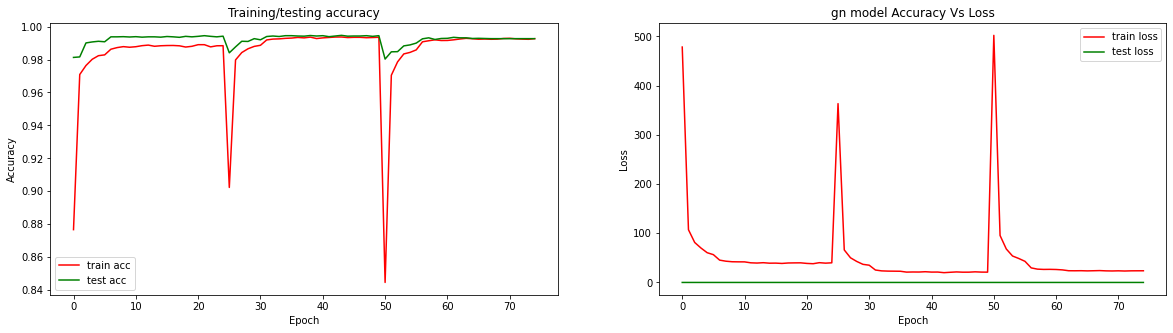

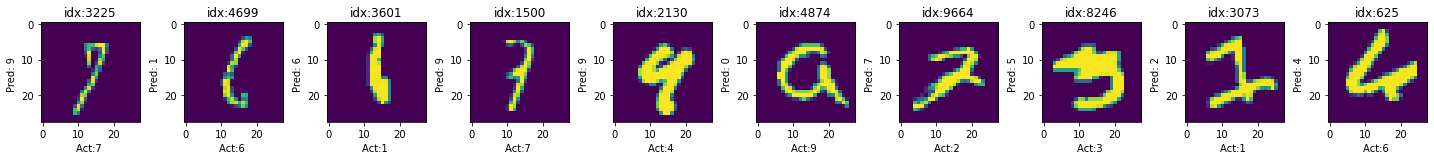

running on cuda 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
         GroupNorm-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
        GroupNorm-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14 

Epochs: 0 Batch:  937 loss: 0.054813507944345474 Accuracy: 84.81% : 100%|██████████| 938/938 [00:15<00:00, 59.00it/s]



Test set: Average loss: 0.0019, Accuracy: 9665/10000 (96.650000%)



Epochs: 1 Batch:  937 loss: 0.02839069999754429 Accuracy: 96.86% : 100%|██████████| 938/938 [00:16<00:00, 57.89it/s]



Test set: Average loss: 0.0010, Accuracy: 9823/10000 (98.230000%)



Epochs: 2 Batch:  937 loss: 0.04940401762723923 Accuracy: 97.78% : 100%|██████████| 938/938 [00:15<00:00, 58.96it/s]



Test set: Average loss: 0.0009, Accuracy: 9832/10000 (98.320000%)



Epochs: 3 Batch:  937 loss: 0.1898278445005417 Accuracy: 98.18% : 100%|██████████| 938/938 [00:16<00:00, 58.56it/s]



Test set: Average loss: 0.0007, Accuracy: 9841/10000 (98.410000%)



Epochs: 4 Batch:  937 loss: 0.08828476071357727 Accuracy: 98.37% : 100%|██████████| 938/938 [00:16<00:00, 57.51it/s]



Test set: Average loss: 0.0005, Accuracy: 9911/10000 (99.110000%)



Epochs: 5 Batch:  937 loss: 0.013529151678085327 Accuracy: 98.49% : 100%|██████████| 938/938 [00:15<00:00, 58.82it/s]



Test set: Average loss: 0.0005, Accuracy: 9898/10000 (98.980000%)



Epochs: 6 Batch:  937 loss: 0.11303086578845978 Accuracy: 99.04% : 100%|██████████| 938/938 [00:16<00:00, 58.59it/s]



Test set: Average loss: 0.0004, Accuracy: 9924/10000 (99.240000%)



Epochs: 7 Batch:  937 loss: 0.007354103494435549 Accuracy: 99.09% : 100%|██████████| 938/938 [00:16<00:00, 58.55it/s]



Test set: Average loss: 0.0003, Accuracy: 9933/10000 (99.330000%)



Epochs: 8 Batch:  937 loss: 0.017016766592860222 Accuracy: 99.13% : 100%|██████████| 938/938 [00:15<00:00, 58.65it/s]



Test set: Average loss: 0.0004, Accuracy: 9924/10000 (99.240000%)



Epochs: 9 Batch:  937 loss: 0.04710691422224045 Accuracy: 99.17% : 100%|██████████| 938/938 [00:15<00:00, 58.67it/s]



Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.270000%)



Epochs: 10 Batch:  937 loss: 0.10341368615627289 Accuracy: 99.14% : 100%|██████████| 938/938 [00:16<00:00, 57.76it/s]



Test set: Average loss: 0.0003, Accuracy: 9929/10000 (99.290000%)



Epochs: 11 Batch:  937 loss: 0.0013772265519946814 Accuracy: 99.13% : 100%|██████████| 938/938 [00:16<00:00, 58.41it/s]



Test set: Average loss: 0.0003, Accuracy: 9930/10000 (99.300000%)



Epochs: 12 Batch:  937 loss: 0.001766007742844522 Accuracy: 99.21% : 100%|██████████| 938/938 [00:16<00:00, 57.93it/s]



Test set: Average loss: 0.0003, Accuracy: 9936/10000 (99.360000%)



Epochs: 13 Batch:  937 loss: 0.013274010270833969 Accuracy: 99.18% : 100%|██████████| 938/938 [00:16<00:00, 58.58it/s]



Test set: Average loss: 0.0003, Accuracy: 9936/10000 (99.360000%)



Epochs: 14 Batch:  937 loss: 0.023794937878847122 Accuracy: 99.16% : 100%|██████████| 938/938 [00:16<00:00, 58.45it/s]



Test set: Average loss: 0.0003, Accuracy: 9933/10000 (99.330000%)



Epochs: 15 Batch:  937 loss: 0.00869914423674345 Accuracy: 99.20% : 100%|██████████| 938/938 [00:15<00:00, 59.03it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 16 Batch:  937 loss: 0.002901050727814436 Accuracy: 99.18% : 100%|██████████| 938/938 [00:15<00:00, 59.88it/s]



Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.390000%)



Epochs: 17 Batch:  937 loss: 0.07371256500482559 Accuracy: 99.22% : 100%|██████████| 938/938 [00:15<00:00, 59.14it/s]



Test set: Average loss: 0.0003, Accuracy: 9937/10000 (99.370000%)



Epochs: 18 Batch:  937 loss: 0.0026552246417850256 Accuracy: 99.27% : 100%|██████████| 938/938 [00:15<00:00, 58.77it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 19 Batch:  937 loss: 0.0021622071508318186 Accuracy: 99.22% : 100%|██████████| 938/938 [00:16<00:00, 58.08it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 20 Batch:  937 loss: 0.003384349402040243 Accuracy: 99.20% : 100%|██████████| 938/938 [00:15<00:00, 58.85it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 21 Batch:  937 loss: 0.049235325306653976 Accuracy: 99.18% : 100%|██████████| 938/938 [00:15<00:00, 58.92it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 22 Batch:  937 loss: 0.002322203479707241 Accuracy: 99.23% : 100%|██████████| 938/938 [00:16<00:00, 58.06it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 23 Batch:  937 loss: 0.0026962552219629288 Accuracy: 99.22% : 100%|██████████| 938/938 [00:16<00:00, 58.36it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



Epochs: 24 Batch:  937 loss: 0.0038867194671183825 Accuracy: 99.22% : 100%|██████████| 938/938 [00:15<00:00, 58.86it/s]



Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.380000%)



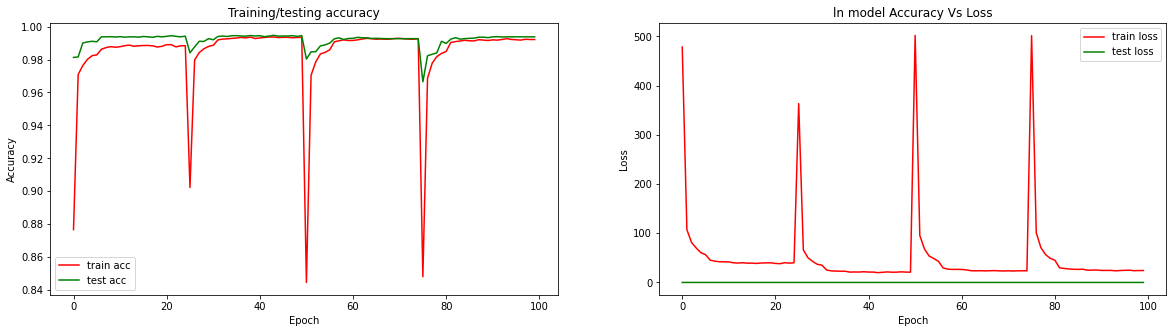

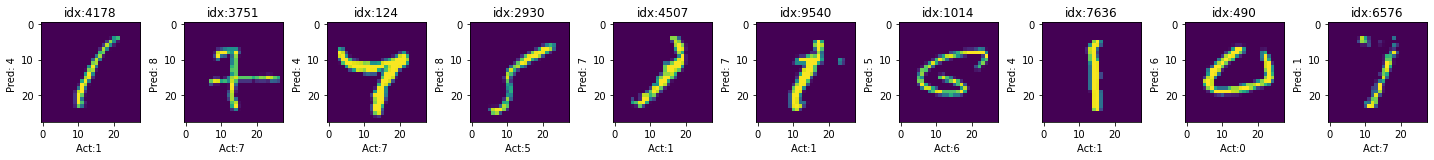

In [20]:
if __name__ == "__main__":
    batch_size = 64
    epochs = 25

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data()
    #take input as normal_type ['gbn','bn','gn','ln']

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test,batch_size=batch_size,**args)
    # ['gbn','bn','gn','ln']
    try_type = ['gbn','bn','gn','ln']
    for norm_type in try_type:
        normalization_type = norm_type

        model_class = Mnist_net( norm_type = normalization_type)
        model,train_losses, train_accuracy,test_losses,test_accuracy = Run_Model(model_class,train_loader,test_loader,epochs =epochs)

        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()
    
        test_data = test.test_data
        test_labels = test.test_labels
        print_wrong_image(model ,device,test_data,test_labels,n_images = 10)

        clean_gpu()

In [21]:
%autosave 1

Autosaving every 1 seconds
